# Деплой, инференс и продовая жизнь моделей

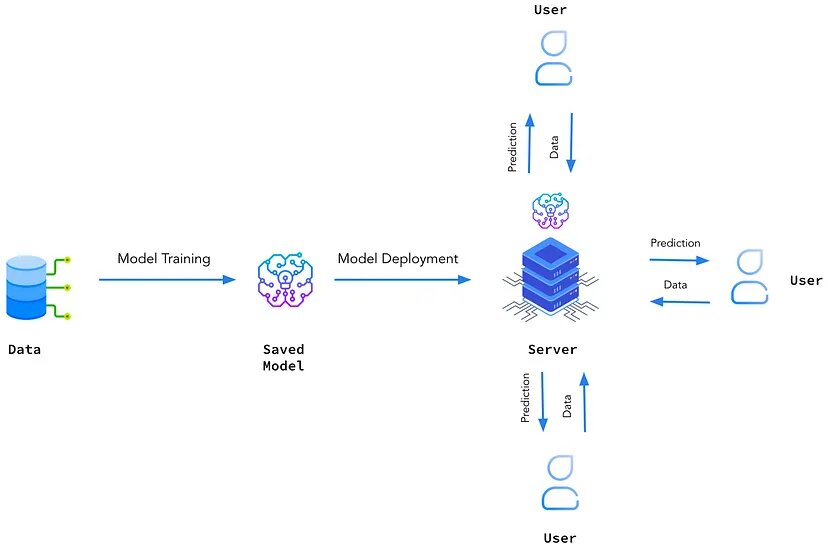

## Деплой моделей

### Как деплоить классические модели?

Никак) Они уже в деплой формате. Достаточно подготовить среду и взять обученные веса моделей.

Для того, чтобы сохранить модель можно воспользоваться двумя путями:

#### Сохранение модели как обьекта

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error
import numpy as np
import pickle

X, y = make_regression()

model = LinearRegression()
model.fit(X, y + np.random.normal(0.0, 1.0, y.shape))

print('Error:', mean_absolute_error(model.predict(X), y))

pickle.dump(model, open('assets/test_model.pkl', 'wb'))

Error: 0.7932027067190566


In [29]:
model = pickle.load(open('assets/test_model.pkl', 'rb'))
print('Error:', mean_absolute_error(model.predict(X), y))

Error: 0.7932027067190566


#### Сохранение весов (где это возможно)

In [36]:
X, y = make_regression()

model = LinearRegression()
model.fit(X, y + np.random.normal(0.0, 1.0, y.shape))
print('Error:', mean_absolute_error(model.predict(X), y))

weights, intercept = model.coef_, model.intercept_

print(weights, intercept)

pickle.dump((weights, intercept), open('assets/test_weights.pkl', 'wb'))

Error: 0.7554588170303883
[-1.34346358e+00  1.82576504e-01  1.38152777e+00 -3.99149051e-01
 -1.17197164e+00  4.34639978e+01  3.47749817e-01 -3.36270868e+00
  7.71837195e+00 -9.57132224e-01  3.12242790e+00 -1.94876917e+00
  4.74448324e+01 -1.48251633e+00  3.93598211e+01  2.38615585e+00
 -2.47980719e+00 -3.02035633e+00  4.90438871e+00  1.37430986e+00
 -3.08663250e+00 -5.41998049e+00  1.27685826e+00 -5.19413311e+00
  3.26874545e+00 -9.52397536e+00  9.94215274e-01 -8.81716717e-01
 -3.49971162e+00  2.15693821e+00  2.66478323e-01  2.41281994e+00
  5.27027191e+00 -1.18883064e+00  6.09317238e+00  1.19834441e+00
 -1.41858102e+00 -6.54796276e-01 -3.28061464e+00 -1.09328429e+00
  1.69743780e+00  3.73170430e+00  3.13854232e+00  7.80884531e-01
 -6.06164392e-01  3.90112942e+00 -2.90018349e+00 -4.68493703e+00
  2.99103953e+00  5.17772653e-01  3.93329945e+00  3.59927765e+00
 -1.27116672e+00  3.37400597e+00 -3.16769350e+00  4.14924953e-02
  1.37000314e+00  1.88498369e+00  1.60587700e+01  4.22123586e-01

In [37]:
model = LinearRegression()
weights, intercept = pickle.load(open('assets/test_weights.pkl', 'rb'))
model.coef_ = weights
model.intercept_ = intercept

print('Error:', mean_absolute_error(model.predict(X), y))

Error: 0.7554588170303883


### Как деплоить нейросети?

В любом случае модель надо конверить в ONNX формат

ONNX - общепринятый формат хранение схемы и весов нейросети. Практически все операции и слои поддерживаются с помощью ONNX, так что парится особо не нужно.

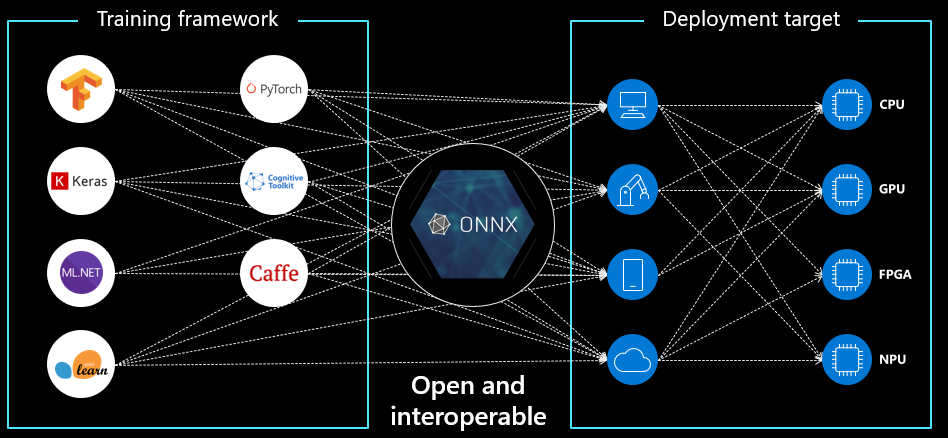

#### Only Torch

In [110]:
import torch

model = torch.nn.Sequential(
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2)
)

model

Sequential(
  (0): Linear(in_features=32, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=2, bias=True)
)

In [111]:
with torch.no_grad():
    print(model(torch.ones(1, 32)))

tensor([[-0.2456, -0.1513]])


In [112]:
torch.save(model.state_dict(), 'assets/model.torch')

In [117]:
state_dict = torch.load('assets/model.torch')
model = torch.nn.Sequential(
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2)
)

model.load_state_dict(state_dict)

<All keys matched successfully>

In [118]:
with torch.no_grad():
    print(model(torch.ones(1, 32)))

tensor([[-0.2456, -0.1513]])


#### TorchScript

In [119]:
import torch

model = torch.nn.Sequential(
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2)
)

with torch.no_grad():
    print(model(torch.ones(1, 32)))

tensor([[0.2117, 0.3819]])


In [120]:
traced = torch.jit.trace(
    model,
    torch.ones(1, 32)
)

traced

Sequential(
  original_name=Sequential
  (0): Linear(original_name=Linear)
  (1): ReLU(original_name=ReLU)
  (2): Linear(original_name=Linear)
)

In [121]:
torch.jit.save(traced, 'assets/model.torchscript')

In [122]:
model = torch.jit.load('assets/model.torchscript')
with torch.no_grad():
    print(model(torch.ones(1, 32)))

tensor([[0.2117, 0.3819]])


#### Torch to ONNX

https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html

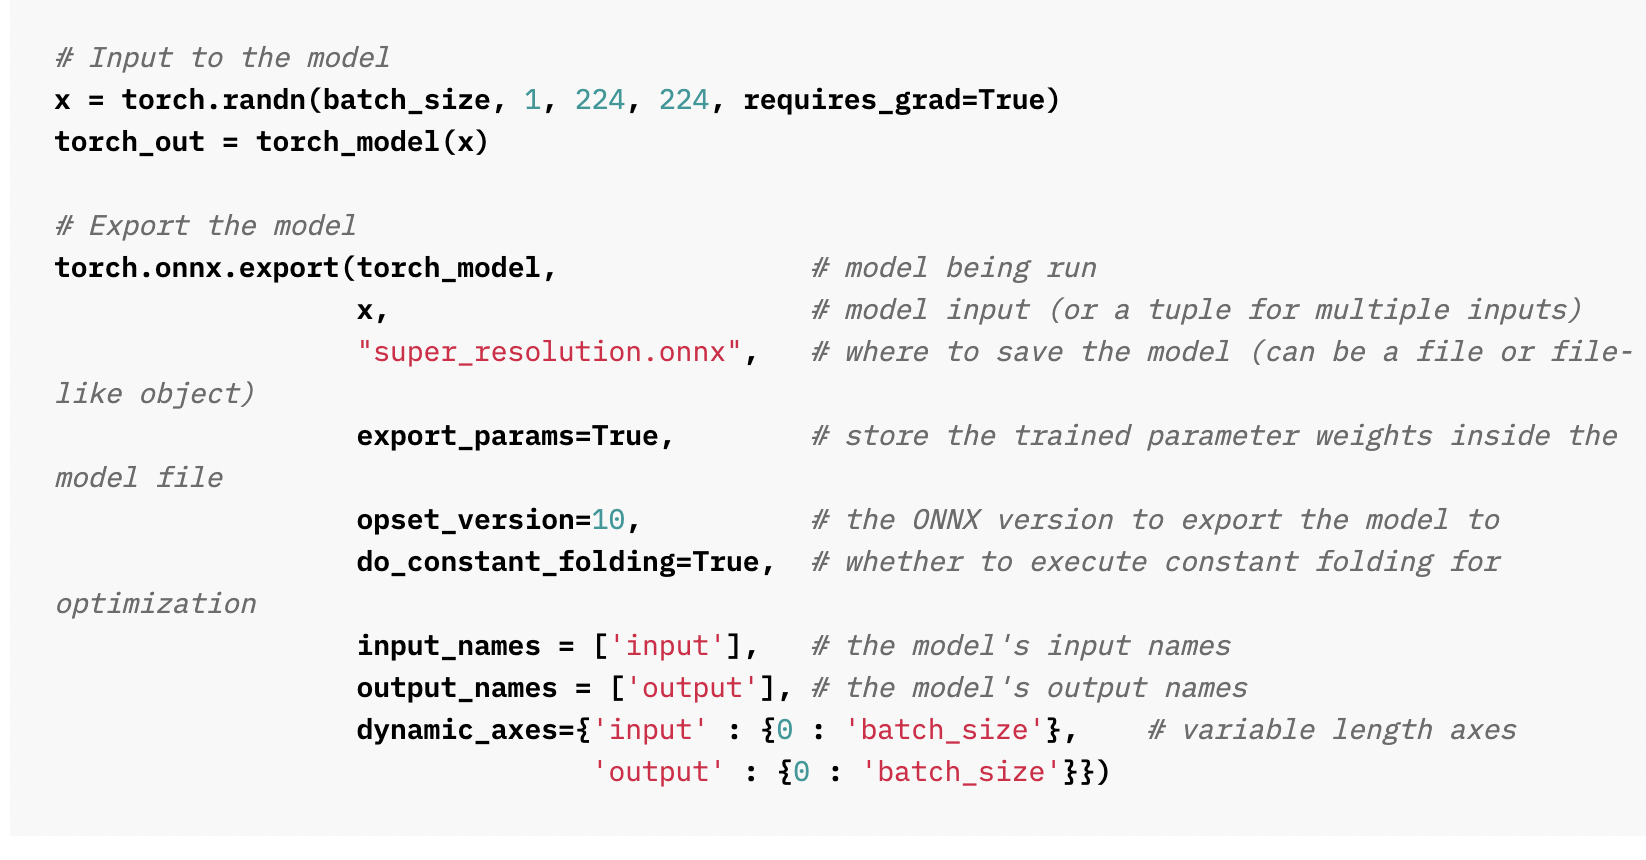

In [74]:
import torch

model = torch.nn.Sequential(
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2)
)


In [75]:
torch.onnx.export(
    model,
    torch.ones(1, 32),
    'assets/model.onnx',
    opset_version=11,
    input_names=['vectors']
)

In [78]:
import onnx

onnx_model = onnx.load('assets/model.onnx')
onnx_model # https://netron.app/

ir_version: 6
opset_import {
  version: 11
}
producer_name: "pytorch"
producer_version: "2.1.1"
graph {
  node {
    input: "vectors"
    input: "0.weight"
    input: "0.bias"
    output: "/0/Gemm_output_0"
    name: "/0/Gemm"
    op_type: "Gemm"
    attribute {
      name: "alpha"
      type: FLOAT
      f: 1
    }
    attribute {
      name: "beta"
      type: FLOAT
      f: 1
    }
    attribute {
      name: "transB"
      type: INT
      i: 1
    }
  }
  node {
    input: "/0/Gemm_output_0"
    output: "/1/Relu_output_0"
    name: "/1/Relu"
    op_type: "Relu"
  }
  node {
    input: "/1/Relu_output_0"
    input: "2.weight"
    input: "2.bias"
    output: "7"
    name: "/2/Gemm"
    op_type: "Gemm"
    attribute {
      name: "alpha"
      type: FLOAT
      f: 1
    }
    attribute {
      name: "beta"
      type: FLOAT
      f: 1
    }
    attribute {
      name: "transB"
      type: INT
      i: 1
    }
  }
  name: "main_graph"
  initializer {
    dims: 64
    dims: 32
    data_

In [79]:
onnx.checker.check_model(onnx_model)

#### TensorRT

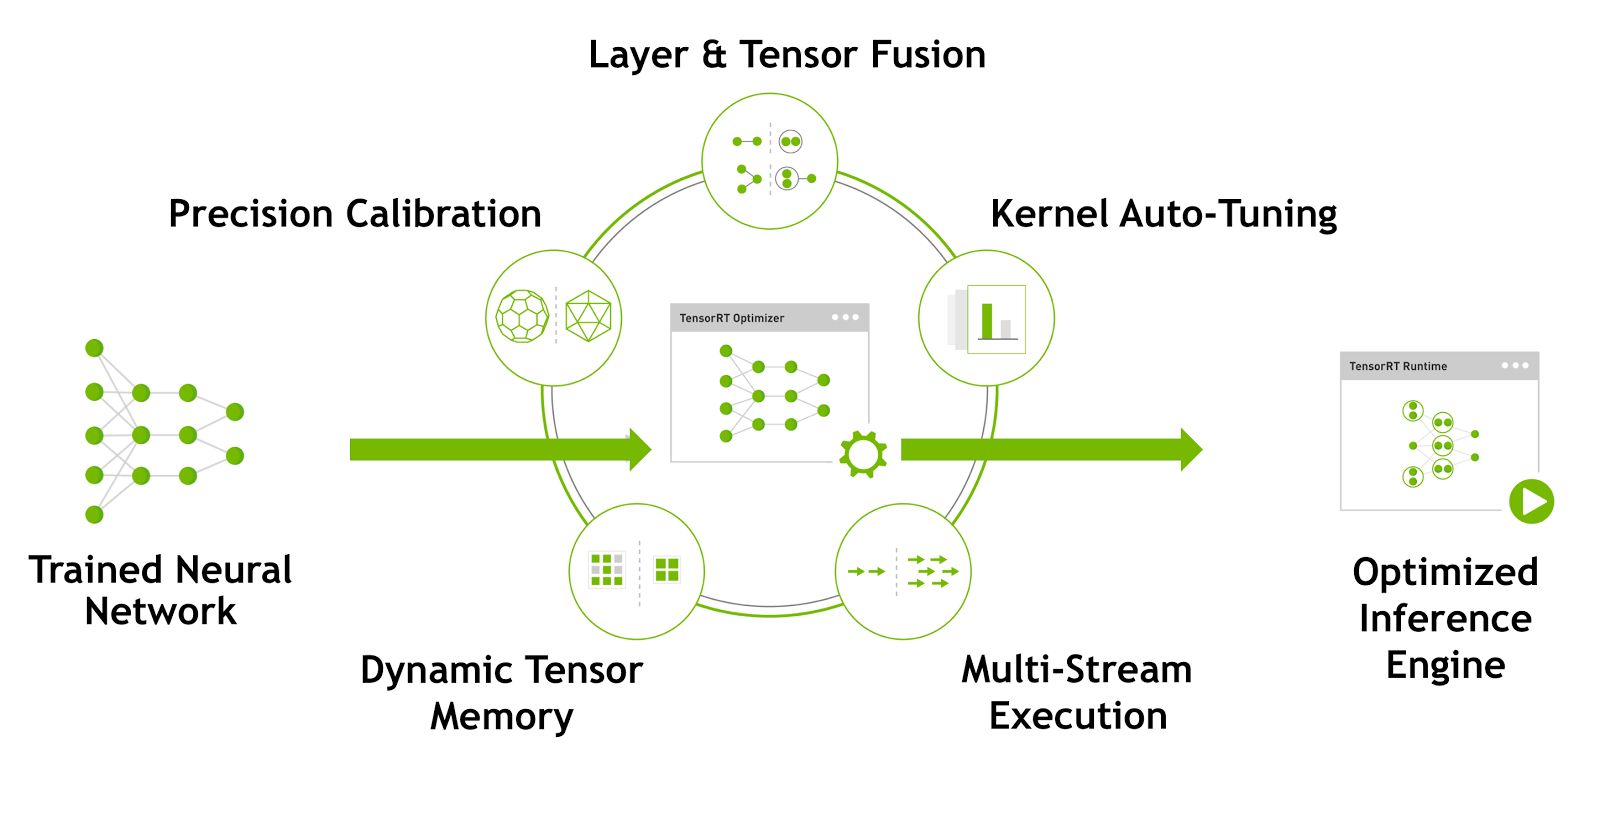

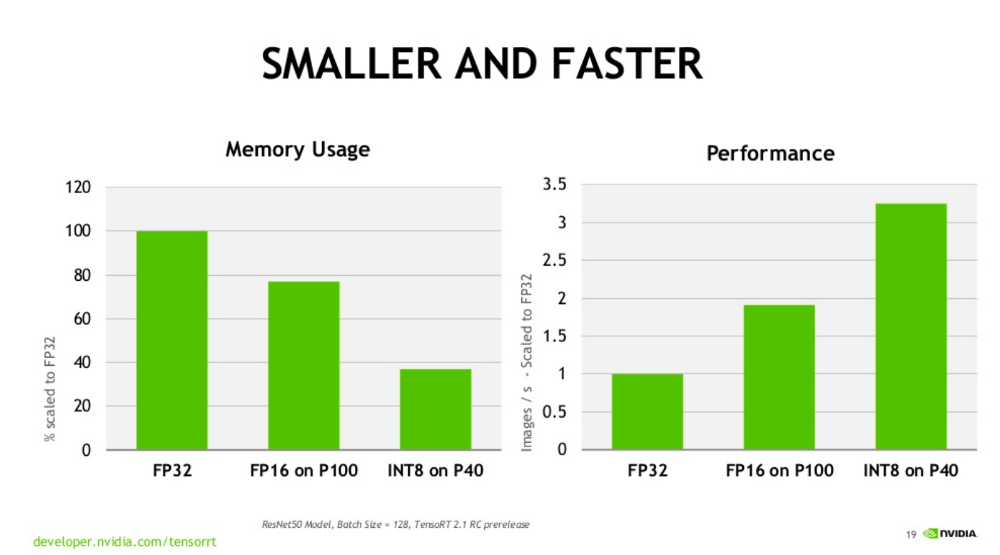

##### Half precision

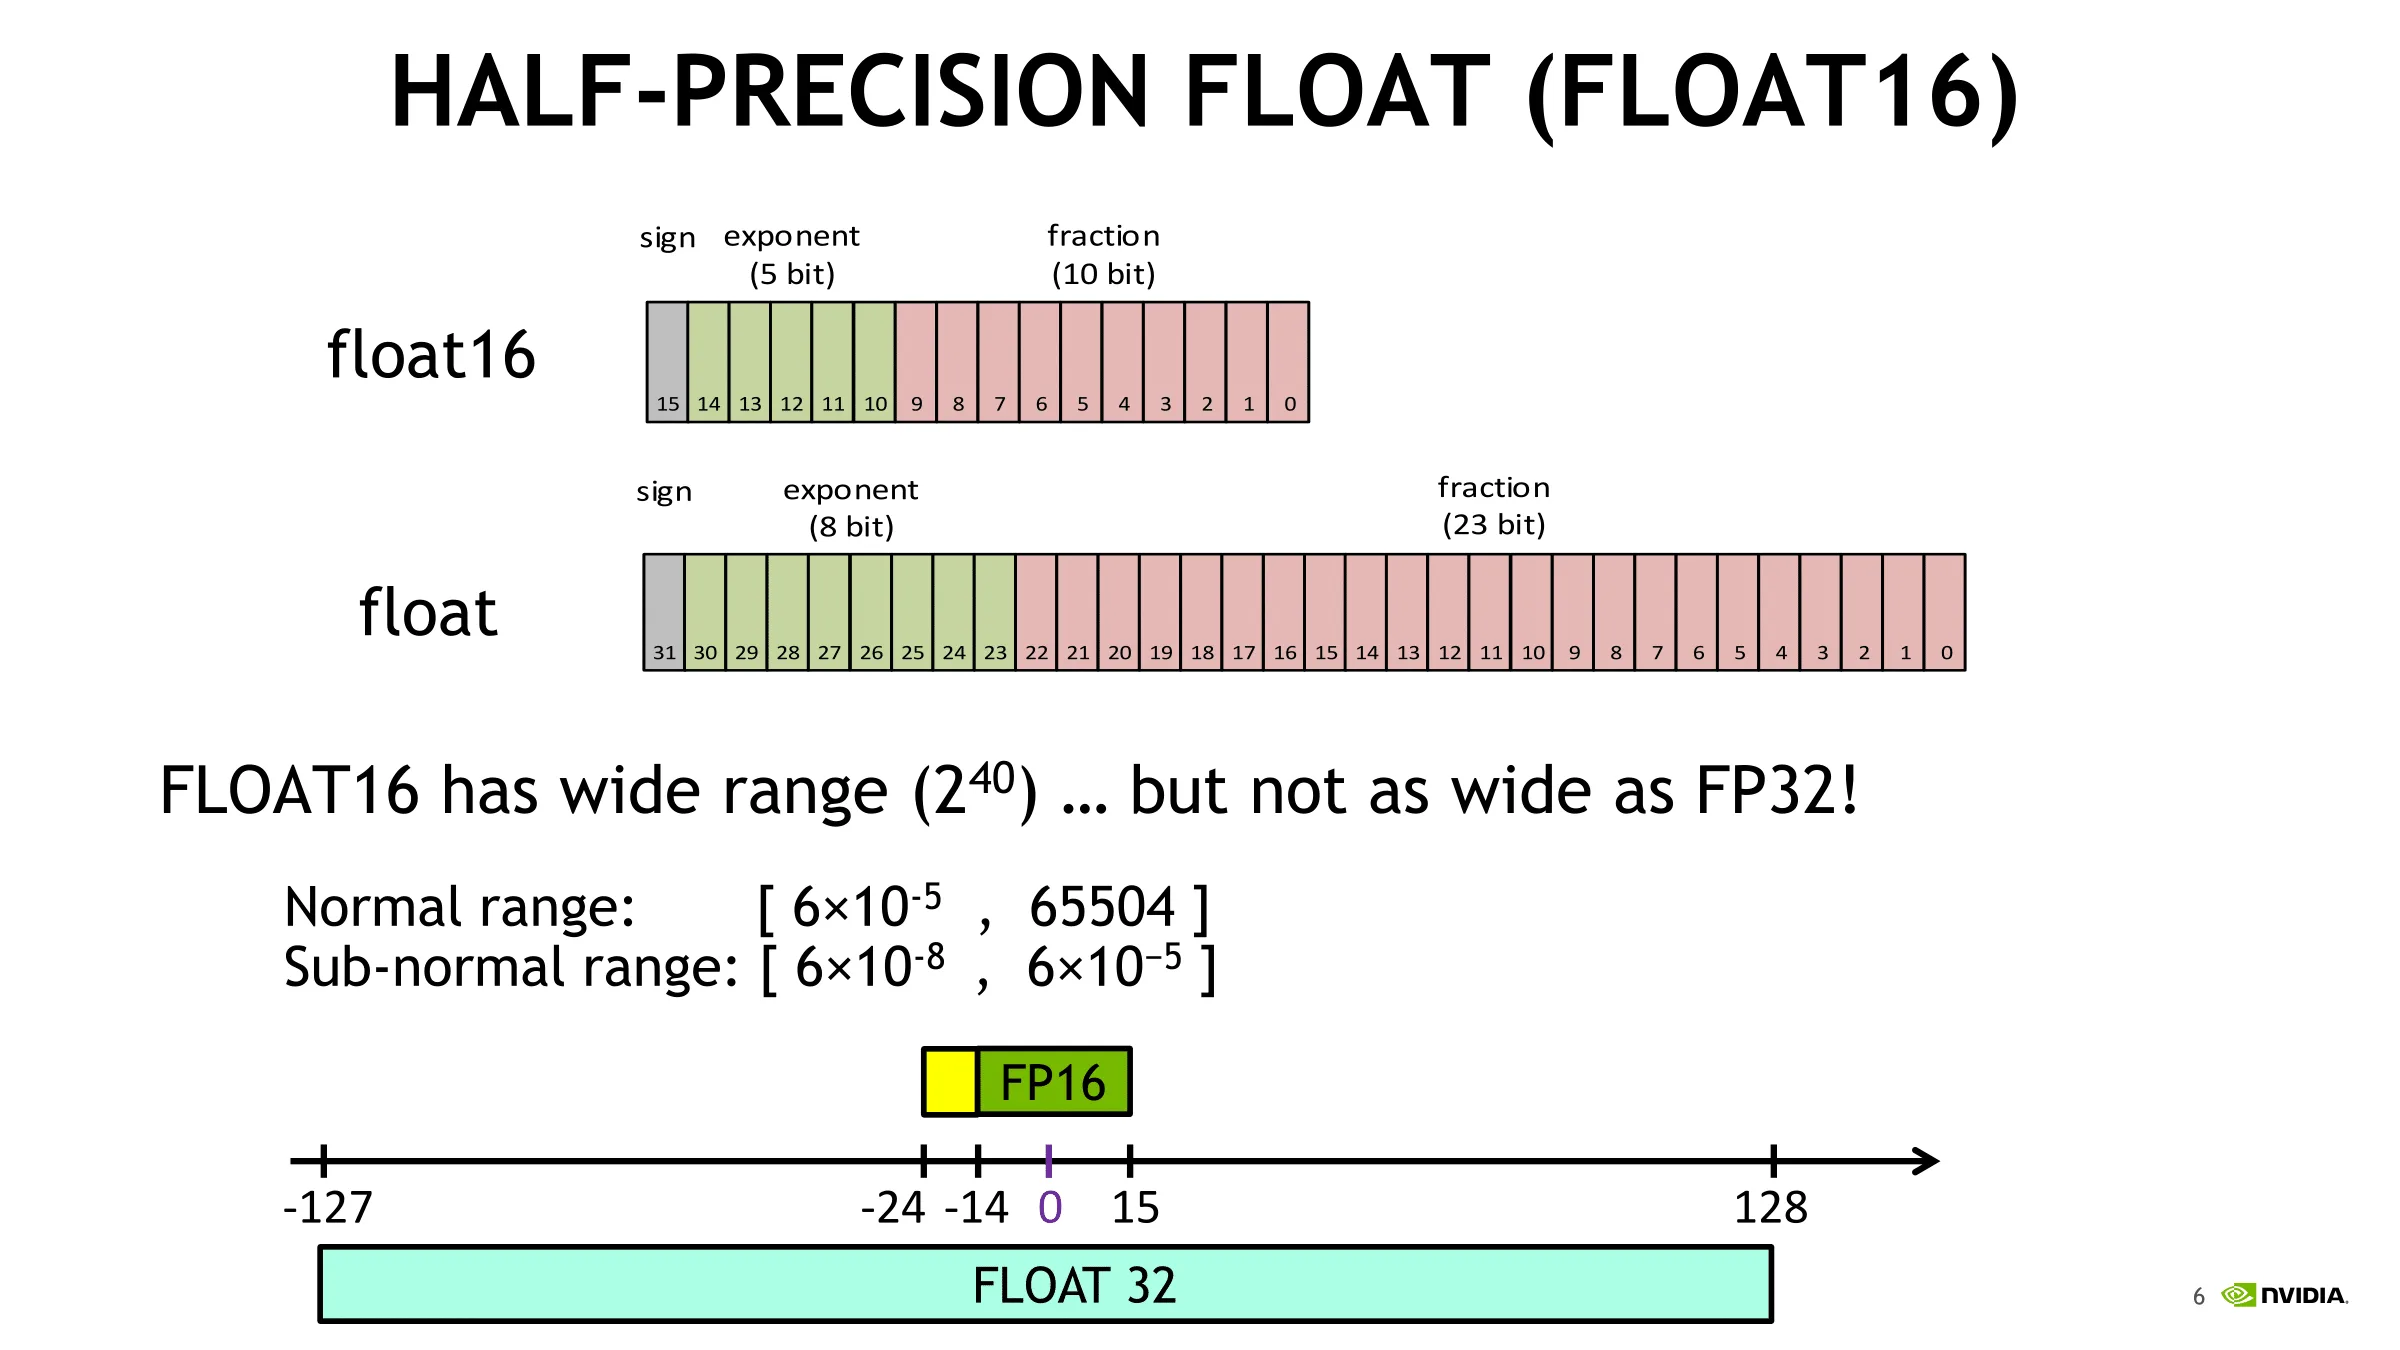

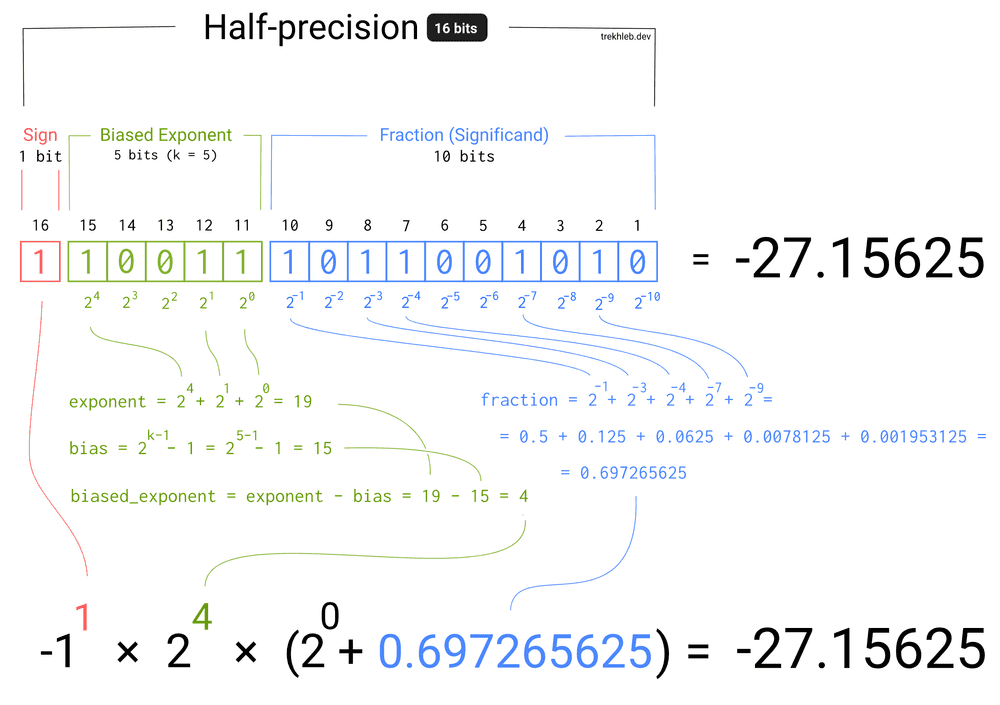

##### Int8

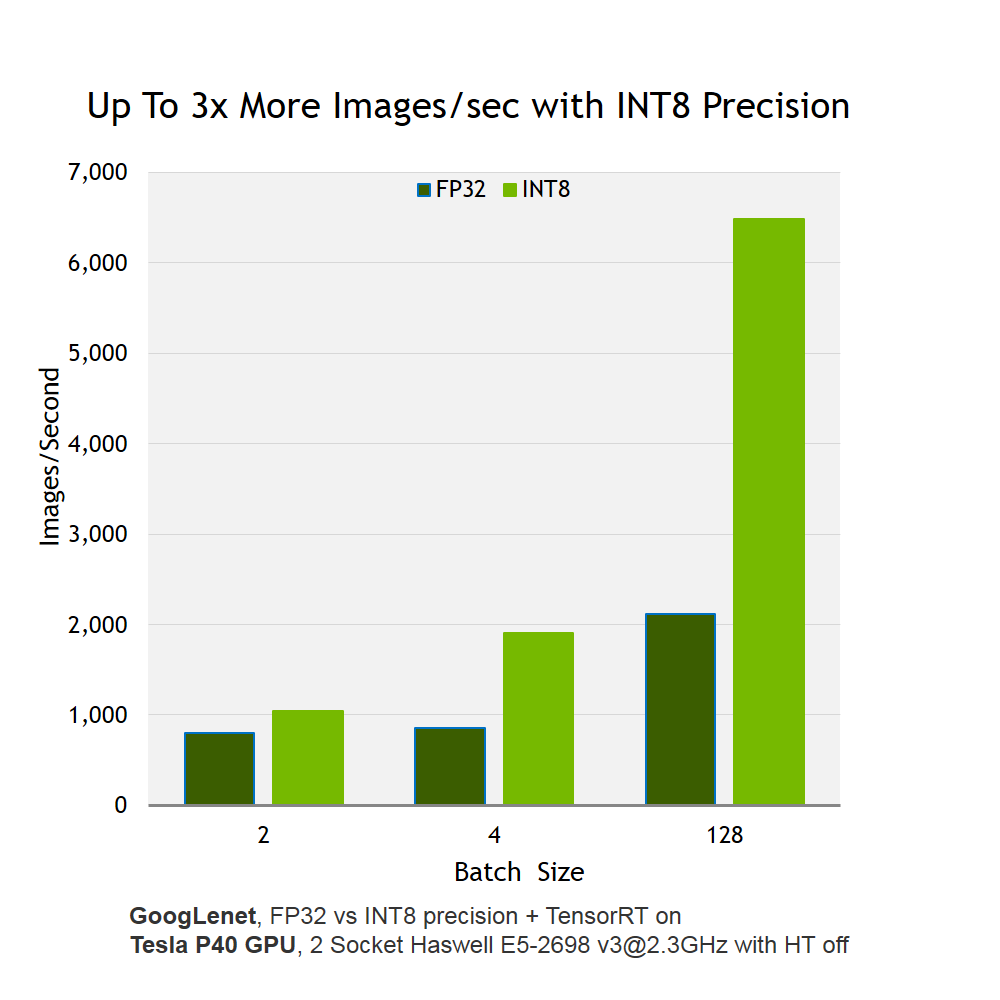

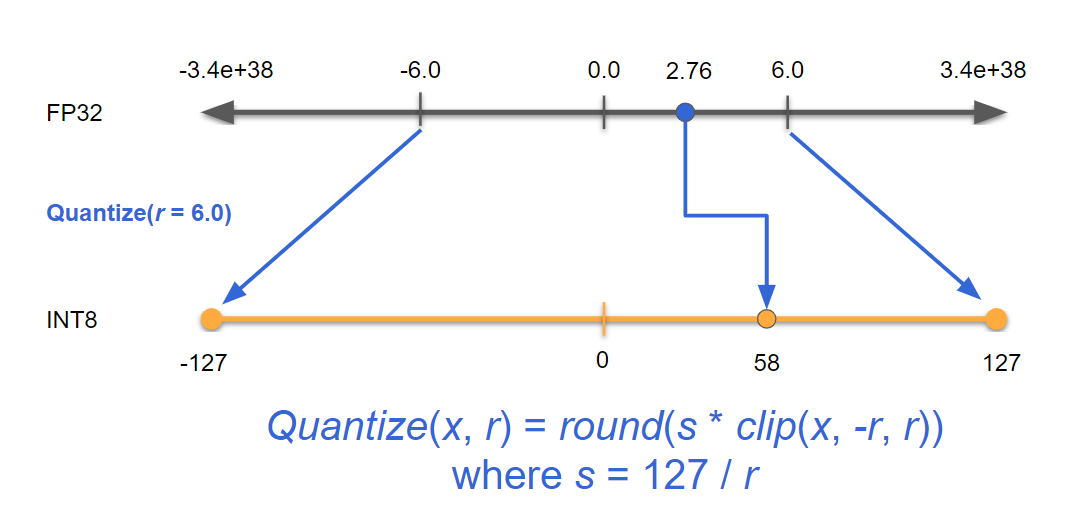

```

Базовая команда конвертации после настройки среды:
```
trtexec --onnx=resnet50/model.onnx --saveEngine=resnet_engine.trt
```

А как вообще происходит оптмизация нейросети?

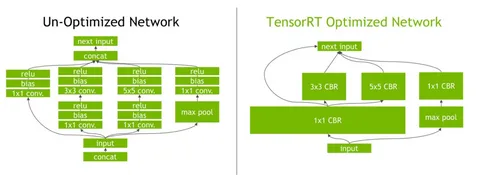

## Инференс моделей

Интерес представляют только нейрости, тк классические модели уже находятся с сессии инференса

### Torch

In [126]:
import torch

model = torch.jit.load('assets/model.torchscript')
model

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
)

In [127]:
with torch.inference_mode():
    print(model(torch.rand(1, 32)))

tensor([[0.1619, 0.2134]])


### ONNXRuntime

https://onnxruntime.ai/

In [123]:
import onnxruntime as ort

session = ort.InferenceSession(
    'assets/model.onnx'
)
session

In [125]:
session.run(
    None,
    {
        'vectors': np.ones((1, 32), dtype=np.float32)
    }
)

[array([[0.33698428, 0.06223579]], dtype=float32)]

In [92]:
session.get_inputs()

In [95]:
session.get_inputs()[0].name, session.get_inputs()[0].shape

('vectors', [1, 32])

In [96]:
session.get_outputs()

In [97]:
session.get_outputs()[0].name, session.get_outputs()[0].shape

('7', [1, 2])

In [98]:
session.get_providers()

['CPUExecutionProvider']

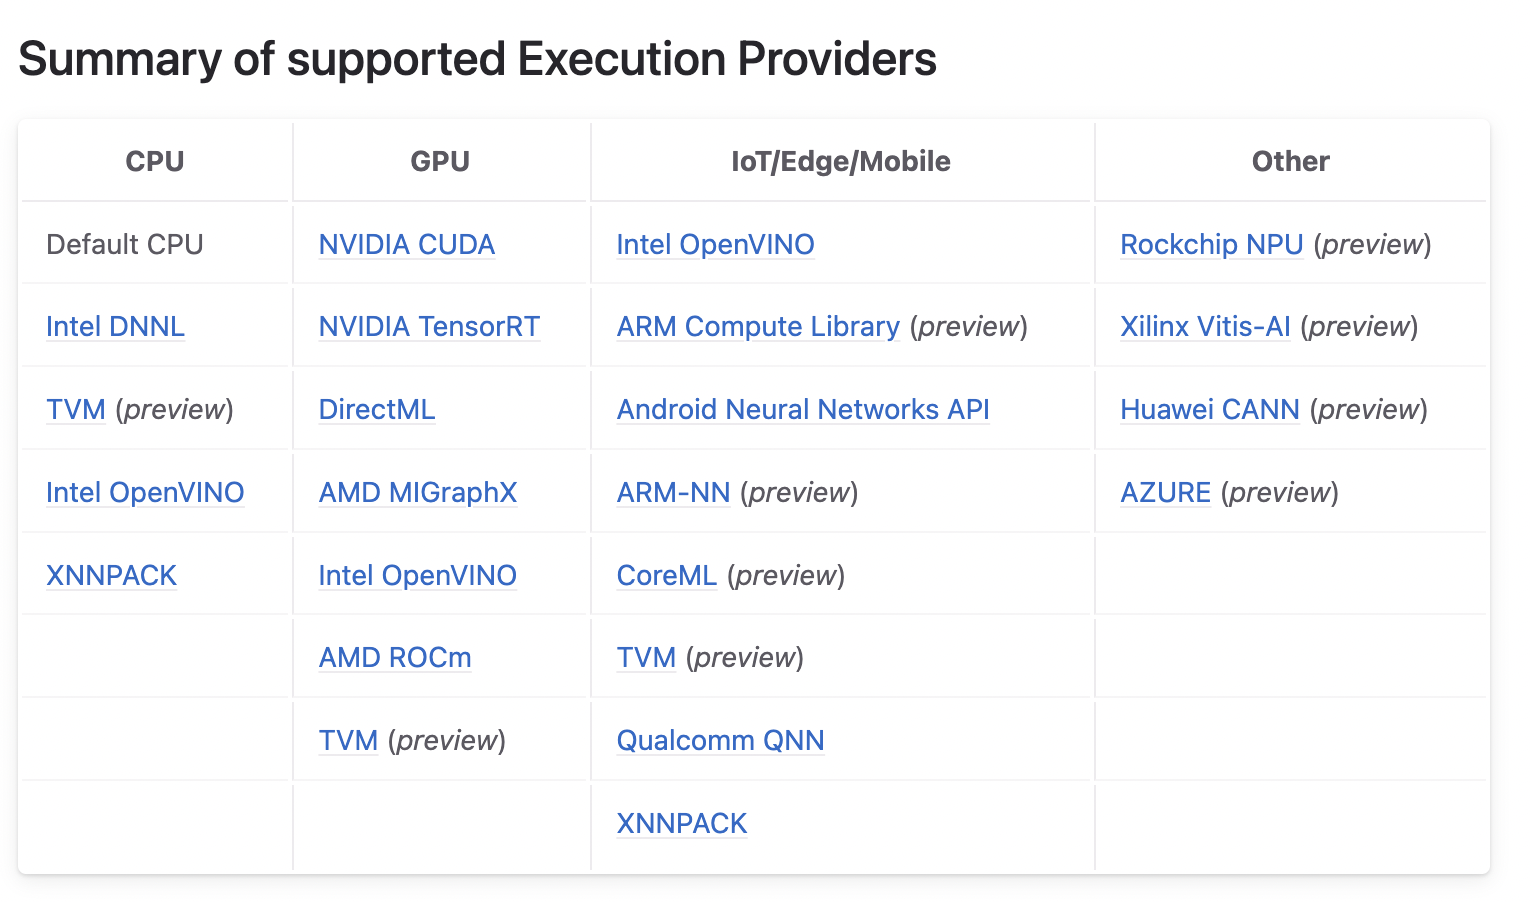

https://github.com/microsoft/onnxruntime/blob/main/dockerfiles/README.md - тут можно посмотреть как билдить докер контейнеры с настроенныой средой для инференса на разных архитектурах процессоров

### Сравнение torch и onnxruntime

In [99]:
from torchvision.models import resnet18
from time import time

model = resnet18()

st = time()

times = []
for _ in range(100):
    input = torch.rand(1, 3, 128, 128)

    st = time()
    with torch.inference_mode():
        o = model(input)
    times.append(time() - st)


print(np.mean(times), np.median(times))

0.012378723621368408 0.01197504997253418


In [100]:
torch.onnx.export(
    model,
    torch.rand(1, 3, 128, 128),
    'assets/resnet.onnx',
    export_params=True,
    opset_version=11,
    input_names=['inputs']
)

In [102]:
import onnxruntime as ort

session = ort.InferenceSession(
    'assets/resnet.onnx'
)

st = time()

times = []
for _ in range(100):
    input = torch.rand(1, 3, 128, 128).numpy()

    st = time()
    o = session.run(None, {'inputs' :input})
    times.append(time() - st)


print(np.mean(times), np.median(times))

0.004759938716888428 0.004704475402832031


### А во что, собственно, оборачивать модель?

Как хотите, на самом деле)

Для того, чтобы у вашей модели была веб морда, можно использвать:

- FastAPI
- Flask
- Django
- и тд

Для виртуализации вашего решения:

- Python enviroment
- Облачные сервера
- Docker
- Podman
- и тд

Лучшее базовое решение - ***FastAPI + Docker***

## Продовая жизнь моделей

### Системные метрики моделей

- FPS модели
- Используемая память модели
- Нагрузка на процессор
- и тд

### Базовые онлайн метрики

#### Общие

- Среднее
- Дисперсия
- Квантили
- и тд

#### Классификация

- Наибольшая вероятность класса
- Распределение классов
- Распределение вероятностей классов
- и тд

### Логгирование артефактов

#### Что есть артефакт

В нашем кейсе любое подозрительное предсказание - артефакт. Подозрительным оно называется тогда, когда модель не может с точной уверенностью дать ответ.

#### Что с ними делать

Сохраняем в облако или в хранилище артефактов

### Базовые методы онлайн дообучения моделей

- Подмешивание новых данных
- Подмешивание сложных кейсов из новых данных
- Дистиляция

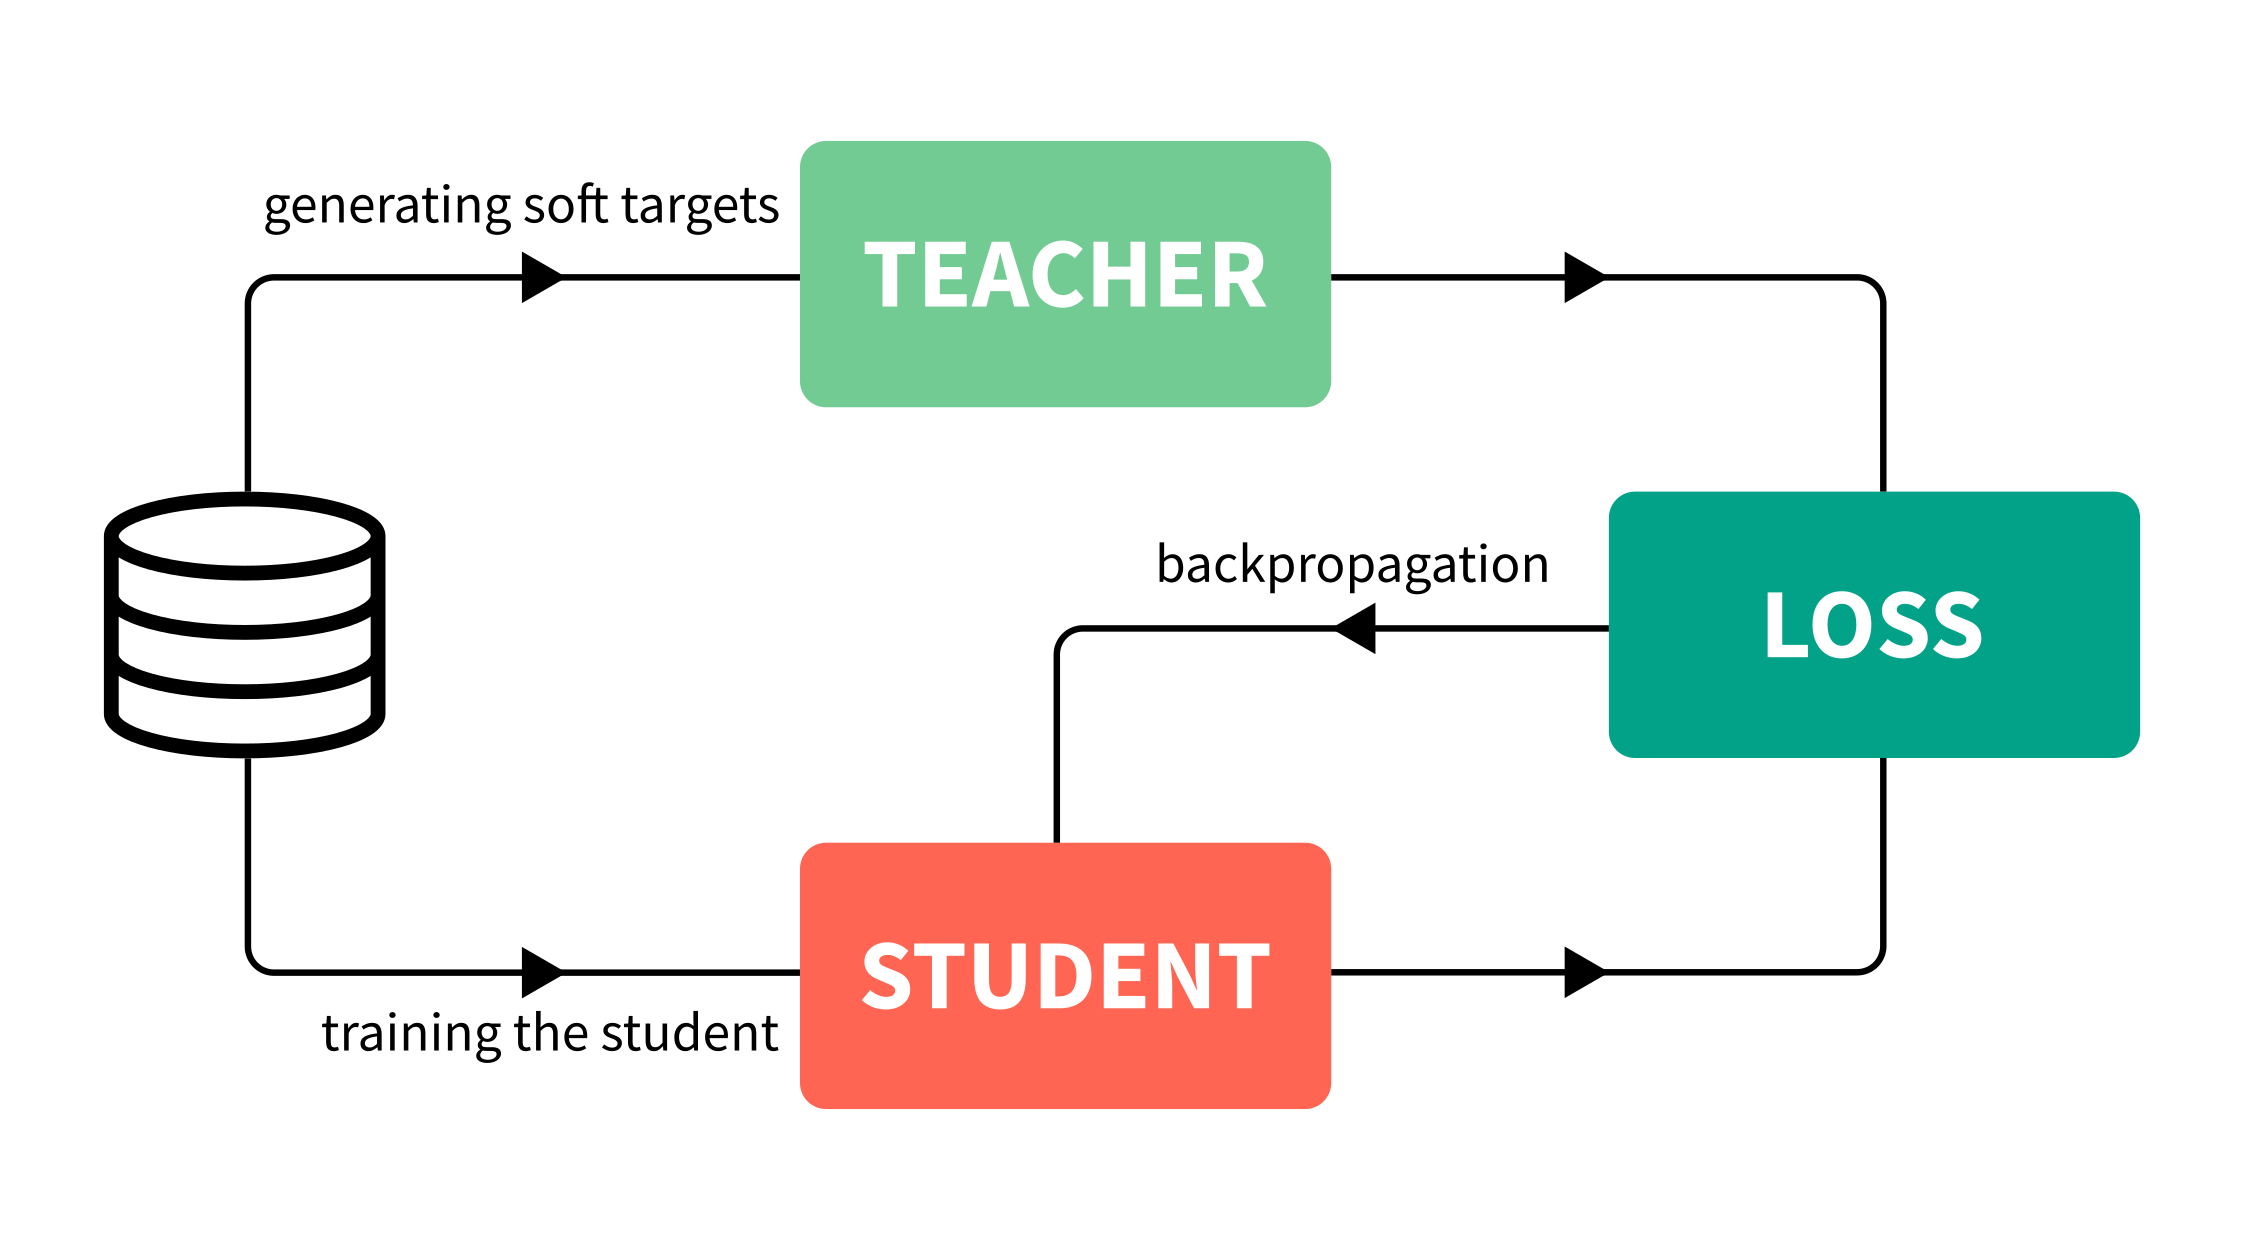

- Методы доменной адаптации

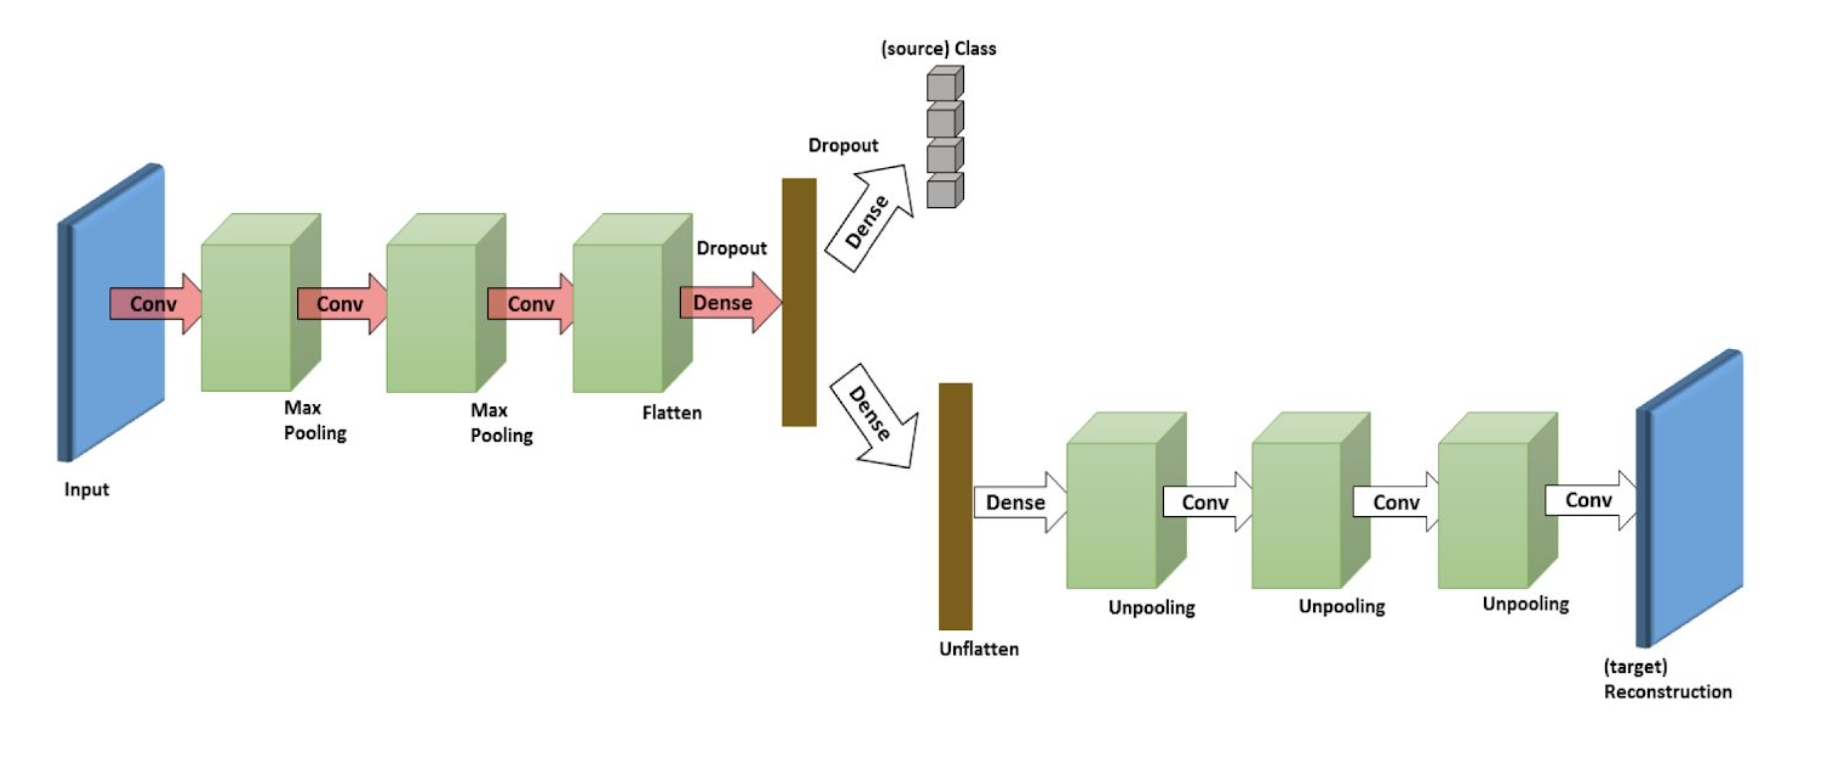

- и тд

### Базовые концепции A/B тестирования

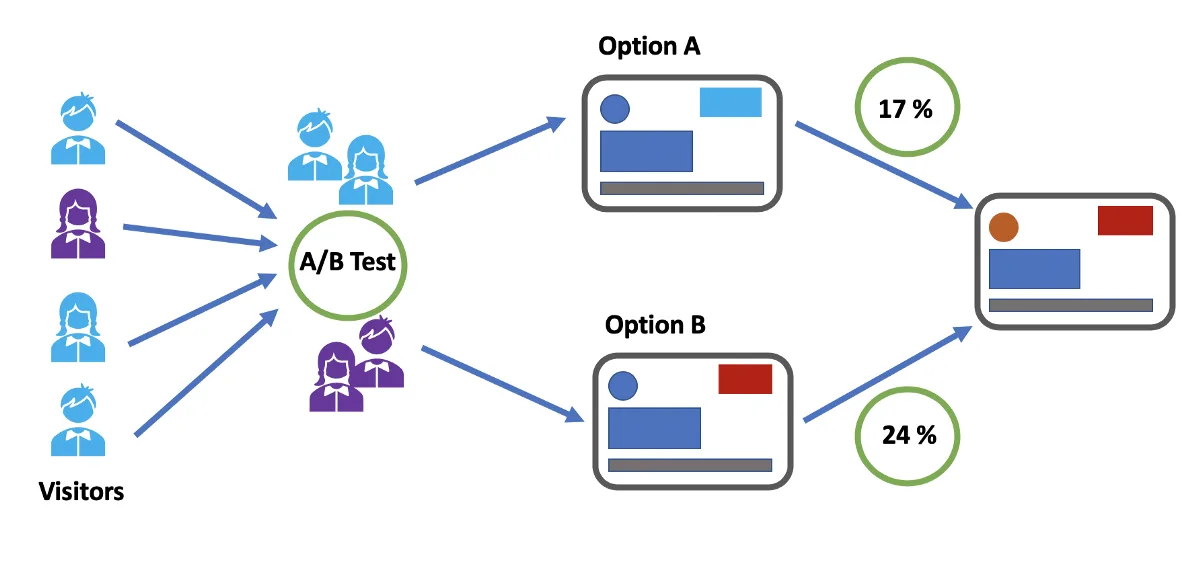

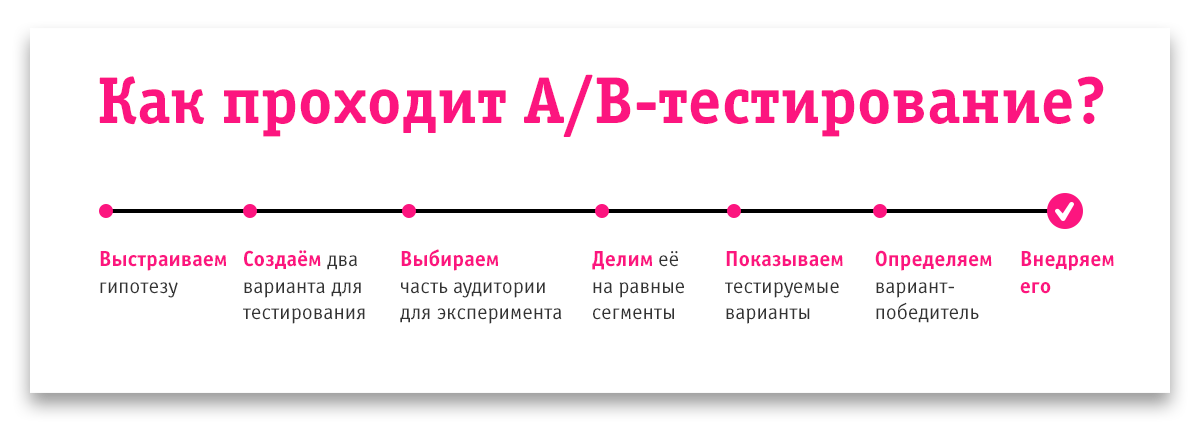

- Поюзерные A/B-тесты

Здесь вы одним пользователям показываете новый дизайн, новые фишки и так далее, а в другой группе оставляете всё как было. Ждёте какой-то срок и смотрите с помощью статистического критерия, прокрашен тест или нет.

- Региональные A/B-тесты

Будем показывать нашу рекламу или введём новые услуги только в половине регионов России. Тогда всё честно: рекламу в одном регионе не увидят пользователи из других регионов (а точнее число тех, кто увидит, будет пренебрежимо мало)

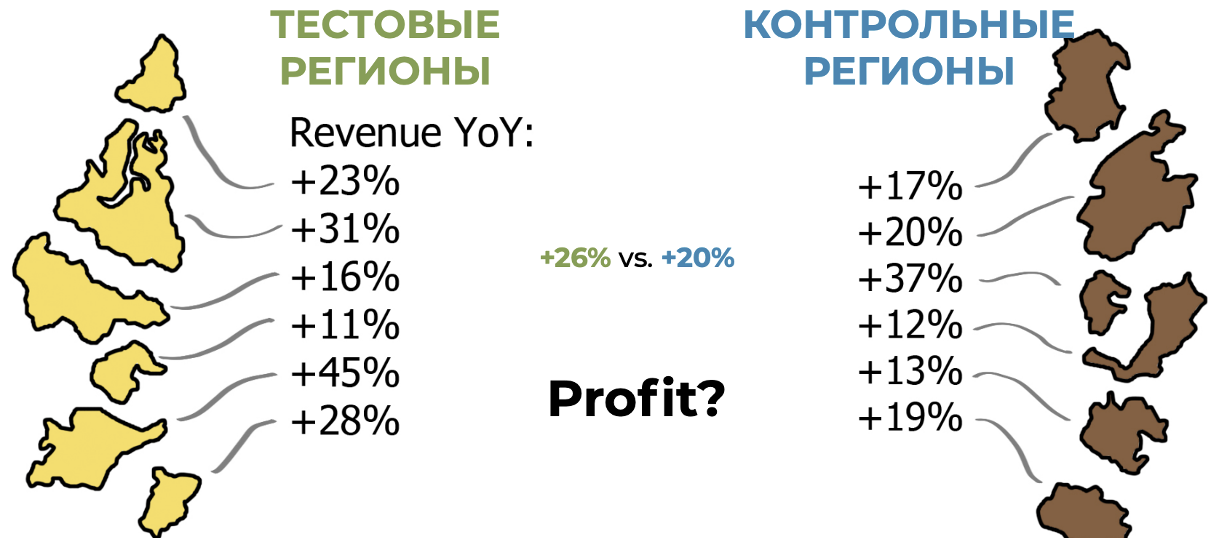

- и тд

## Как размечают данные?

- Руками сами дата саентисты
- Ассесоры внутри компании
- Внешние сервисы:
  - Toloka (https://toloka.yandex.ru/)
  - Яндекс задания (https://tasks.yandex.ru)
  - Supervisely (https://supervisely.com/)
  - и тд

# Code time

Пишем autoML пайплайн для итеративного дообучения нейросети, которая прогнозирует пол, возраст и расу

In [223]:
import pandas as pd
import torch
import numpy as np
from copy import deepcopy
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score



class FaceAttributesModel(torch.nn.Module):
    def __init__(self, in_features):
        super().__init__()
        
        self._fc1 = torch.nn.Linear(in_features, 256)
        self._fc2 = torch.nn.Linear(256, 128)
        
        self._fc_age = torch.nn.Linear(128, 1)
        self._fc_gender = torch.nn.Linear(128, 2)
        self._fc_race = torch.nn.Linear(128, 5)
        
        self._relu = torch.nn.ReLU()

    def forward(self, x):
        x = self._fc1(x)
        x = self._relu(x)
        x = self._fc2(x)
        x = self._relu(x)

        age = self._fc_age(x)
        gender = self._fc_gender(x)
        race = self._fc_race(x)
        
        return age, gender, race

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, return_targets=True):
        self._x = X.copy()
        self._y = y.copy()

    def __len__(self):
        return len(self._x)

    def __getitem__(self, idx):
        x = self._x[idx]
        y = self._y[idx]
        return x, y

class OurModel(object):
    def __init__(self):
        self.model = FaceAttributesModel(in_features=512)

        self.predictions = {
            'age': [],
            'gender': [],
            'race': []
        }

        self.system_metrics = {
            'fps': []
        }

    def train(self, X, y):
        model = FaceAttributesModel(in_features=512)

        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25)

        train_dataset, val_dataset = Dataset(train_X, train_y), Dataset(val_X, val_y)
        
        train_dataloader = torch.utils.data.DataLoader(
            dataset=train_dataset,
            batch_size=8,
            shuffle=True,
            num_workers=0
        )
        val_dataloader = torch.utils.data.DataLoader(
            dataset=val_dataset,
            batch_size=8,
            shuffle=False,
            num_workers=0
        )

        loss_f_age = torch.nn.MSELoss()
        loss_f_gender = torch.nn.CrossEntropyLoss()
        loss_f_race = torch.nn.CrossEntropyLoss()
        
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
        
        num_epochs = 25

        best_model, best_metric = None, -np.inf
        
        for epoch in range(num_epochs):
            model.train()
            lr_scheduler.step()
            sum_loss_value = 0.0
            for batch in train_dataloader:
                optimizer.zero_grad()
                data, targets = batch
                age, gender, race = model(data)
        
                loss_value_age = loss_f_age(age, targets[:, [0]])
        
                loss_value_gender = loss_f_gender(gender, targets[:, 1].long())
        
                loss_value_race = loss_f_race(race, targets[:, 2].long())
                
                loss_value = loss_value_age * 1.0 + loss_value_gender * 100.0 + loss_value_race * 40.0
                loss_value.backward()
                optimizer.step()
                
                sum_loss_value += loss_value.item()
            model.eval()
            metric_value_age, metric_value_gender, metric_value_race, n = 0.0, 0.0, 0.0, 0
            for batch in val_dataloader:
                data, targets = batch
                with torch.no_grad():
                    age, gender, race  = model(data)
                    metric_value_age += torch.nn.functional.l1_loss(age, targets[:, [0]], reduction='sum')
                    metric_value_gender += (gender.argmax(1) == targets[:, 1]).sum()
                    metric_value_race += (race.argmax(1) == targets[:, 2]).sum()
                    n += len(data)

            general_metric = (- metric_value_age + metric_value_gender + metric_value_race) / n

            if general_metric > best_metric:
                best_model = deepcopy(model.state_dict())

                print(f'Best metric increased from {best_metric} to {general_metric}')
                best_metric = general_metric
                # print(f'AGE MAE ERROR: {metric_value_age / n}')
                # print(f'GENDER ACCURACY ERROR: {metric_value_gender / n}')
                # print(f'RACE ACCURACY ERROR: {metric_value_race / n}')

        self.model.load_state_dict(best_model)
        self.model.eval()
        self.predictions = {
            'age': [],
            'gender': [],
            'race': []
        }

        self.system_metrics = {
            'fps': []
        }
        

    def predict(self, X):
        with torch.inference_mode():
            st = time()
            ages, genders, races = self.model(torch.from_numpy(X))
            self.system_metrics['fps'].append(len(X) / (time() - st))

            for age, gender, race in zip(ages, genders, races):
                self.predictions['age'].append(age[0])
                self.predictions['gender'].append(torch.softmax(gender, dim=0))
                self.predictions['race'].append(torch.softmax(race, dim=0))
            
            return [
                {
                    'age': age[0],
                    'gender': gender,
                    'race': race
                }
                for age, gender, race in zip(ages, genders, races)
            ]

    def metrics_eval(self, X, y):
        with torch.inference_mode():
            age, gender, race = self.model(torch.from_numpy(X))
        metric_value_age = mean_absolute_error(age.view(-1).numpy(), y[:, [0]])
        metric_value_gender = accuracy_score(gender.argmax(1).numpy(), y[:, 1])
        metric_value_race = accuracy_score(race.argmax(1).numpy(), y[:, 2])
        print(f'AGE MAE ERROR: {metric_value_age}')
        print(f'GENDER ACCURACY ERROR: {metric_value_gender}')
        print(f'RACE ACCURACY ERROR: {metric_value_race}')
        
        

    def get_artifacts(self, predictions):
        artifacts = []

        for idx, prediction in enumerate(predictions):
            age, gender, race = prediction['age'], prediction['gender'], prediction['race']

            if np.abs(age - np.mean(self.predictions['age'])) > 2 * np.std(self.predictions['age']):
                artifacts.append(idx)
                continue

            if gender.max() < 0.9:
                artifacts.append(idx)
                continue
            if race.max() < 0.7:
                artifacts.append(idx)
                continue

        return artifacts
        

In [224]:
dt = pd.read_csv('assets/utk_vecs_train.csv')
dt = dt.sample(frac=1.0).reset_index(drop=True)
X, y = dt.drop(['age', 'gender', 'race'], axis=1).values.astype('float32'), dt[['age', 'gender', 'race']].values.astype('float32')
X, y, X_test, y_test = X[:18000], y[:18000], X[18000:], y[18000:]

In [225]:
model = OurModel()
X_, y_ = X[:2000], y[:2000]

model.train(X_, y_)

for idx in range(2000, len(X), 2000):
    print('======= START NEW ITERATION ==========')
    model.metrics_eval(X_test, y_test)
    predictions = model.predict(X[idx:idx + 2000])
    artifacts = model.get_artifacts(predictions)
    print(f'ARTIFACTS: {len(artifacts)}')

    X_, y_ = np.concatenate([X_, X[idx:idx + 2000][artifacts]]), np.concatenate([y_, y[idx:idx + 2000][artifacts]])

    model.train(X_, y_)
    

/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Best metric increased from -inf to -6.888330936431885
Best metric increased from -6.888330936431885 to -6.026163101196289
Best metric increased from -6.026163101196289 to -5.737610340118408
Best metric increased from -5.737610340118408 to -5.634774684906006
Best metric increased from -5.634774684906006 to -5.4890336990356445
Best metric increased from -5.4890336990356445 to -5.191306114196777
Best metric increased from -5.191306114196777 to -5.146572113037109
Best metric increased from -5.146572113037109 to -5.083980560302734
======= START NEW ITERATION ==========
AGE MAE ERROR: 7.38811731338501
GENDER ACCURACY ERROR: 0.894
RACE ACCURACY ERROR: 0.719
ARTIFACTS: 460


/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Best metric increased from -inf to -6.3791184425354
Best metric increased from -6.3791184425354 to -6.172444820404053
Best metric increased from -6.172444820404053 to -5.839233875274658
Best metric increased from -5.839233875274658 to -5.582130432128906
Best metric increased from -5.582130432128906 to -5.522047996520996
Best metric increased from -5.522047996520996 to -5.493574619293213
Best metric increased from -5.493574619293213 to -5.489199161529541
======= START NEW ITERATION ==========
AGE MAE ERROR: 7.300326347351074
GENDER ACCURACY ERROR: 0.895
RACE ACCURACY ERROR: 0.742
ARTIFACTS: 439


/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Best metric increased from -inf to -8.070392608642578
Best metric increased from -8.070392608642578 to -6.92885684967041
Best metric increased from -6.92885684967041 to -6.724668502807617
Best metric increased from -6.724668502807617 to -6.665865898132324
Best metric increased from -6.665865898132324 to -6.2978105545043945
Best metric increased from -6.2978105545043945 to -5.928328990936279
======= START NEW ITERATION ==========
AGE MAE ERROR: 7.702155590057373
GENDER ACCURACY ERROR: 0.8975
RACE ACCURACY ERROR: 0.7475
ARTIFACTS: 550


/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Best metric increased from -inf to -11.796354293823242
Best metric increased from -11.796354293823242 to -7.556869029998779
Best metric increased from -7.556869029998779 to -6.9358906745910645
Best metric increased from -6.9358906745910645 to -6.821194171905518
Best metric increased from -6.821194171905518 to -6.500120639801025
Best metric increased from -6.500120639801025 to -6.370935916900635
Best metric increased from -6.370935916900635 to -6.363223075866699
Best metric increased from -6.363223075866699 to -6.311025619506836
======= START NEW ITERATION ==========
AGE MAE ERROR: 7.862560749053955
GENDER ACCURACY ERROR: 0.8955
RACE ACCURACY ERROR: 0.7375
ARTIFACTS: 619


/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Best metric increased from -inf to -7.466108322143555
Best metric increased from -7.466108322143555 to -6.1662397384643555
Best metric increased from -6.1662397384643555 to -5.8552327156066895
Best metric increased from -5.8552327156066895 to -5.591110706329346
Best metric increased from -5.591110706329346 to -5.4958391189575195
Best metric increased from -5.4958391189575195 to -5.453676223754883
Best metric increased from -5.453676223754883 to -5.242368698120117
======= START NEW ITERATION ==========
AGE MAE ERROR: 7.23725700378418
GENDER ACCURACY ERROR: 0.8925
RACE ACCURACY ERROR: 0.7495
ARTIFACTS: 228


/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Best metric increased from -inf to -8.775815963745117
Best metric increased from -8.775815963745117 to -6.086672782897949
Best metric increased from -6.086672782897949 to -5.185993194580078
Best metric increased from -5.185993194580078 to -5.1766862869262695
Best metric increased from -5.1766862869262695 to -5.009846210479736
Best metric increased from -5.009846210479736 to -4.966367244720459
Best metric increased from -4.966367244720459 to -4.9489874839782715
Best metric increased from -4.9489874839782715 to -4.944488048553467
======= START NEW ITERATION ==========
AGE MAE ERROR: 7.100932598114014
GENDER ACCURACY ERROR: 0.9005
RACE ACCURACY ERROR: 0.7425
ARTIFACTS: 219


/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Best metric increased from -inf to -6.160831928253174
Best metric increased from -6.160831928253174 to -6.0255279541015625
Best metric increased from -6.0255279541015625 to -5.942012786865234
Best metric increased from -5.942012786865234 to -5.8019819259643555
Best metric increased from -5.8019819259643555 to -5.578174591064453
======= START NEW ITERATION ==========
AGE MAE ERROR: 7.254383563995361
GENDER ACCURACY ERROR: 0.8985
RACE ACCURACY ERROR: 0.749
ARTIFACTS: 833


/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Best metric increased from -inf to -7.194050312042236
Best metric increased from -7.194050312042236 to -6.533535957336426
Best metric increased from -6.533535957336426 to -6.403661251068115
Best metric increased from -6.403661251068115 to -6.042961597442627
Best metric increased from -6.042961597442627 to -5.800850868225098
Best metric increased from -5.800850868225098 to -5.49335241317749
Best metric increased from -5.49335241317749 to -5.423652648925781
Best metric increased from -5.423652648925781 to -5.4131975173950195
Best metric increased from -5.4131975173950195 to -5.371041774749756
======= START NEW ITERATION ==========
AGE MAE ERROR: 7.514647483825684
GENDER ACCURACY ERROR: 0.9025
RACE ACCURACY ERROR: 0.751
ARTIFACTS: 591


/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Best metric increased from -inf to -6.978309154510498
Best metric increased from -6.978309154510498 to -5.862651348114014
Best metric increased from -5.862651348114014 to -5.502154350280762
Best metric increased from -5.502154350280762 to -5.480576515197754
Best metric increased from -5.480576515197754 to -5.224299430847168
Best metric increased from -5.224299430847168 to -5.027486324310303
Best metric increased from -5.027486324310303 to -5.024197101593018
Best metric increased from -5.024197101593018 to -4.964111328125


In [226]:
model.metrics_eval(X_test, y_test)

AGE MAE ERROR: 6.9127583503723145
GENDER ACCURACY ERROR: 0.8915
RACE ACCURACY ERROR: 0.764


In [227]:
X_.shape

(5939, 512)